In [1]:
import os
import pickle
import sys
import warnings

sys.path.append("..")
from src.model_utils import (
    CropMLP,
    CropLSTM,
    CropConvLSTM,
    CropTransformer,
    CroplandDatasetTest,
    CroplandDataset,
    CroplandDataModuleLSTM,
    CropPL,
    custom_multiclass_report,
    reshape_data,
)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from sklearn_evaluation import plot
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from temperature_scaling_osu import ModelWithTemperature

from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [12]:
# Read dictionary pkl files
with open(
    os.path.join("..", "data", "processed_files", "pkls", "X_lstm.pkl"), "rb"
) as fp:
    X_lstm = pickle.load(fp)

with open(
    os.path.join("..", "data", "processed_files", "pkls", "y_lstm.pkl"), "rb"
) as fp:
    y_lstm = pickle.load(fp)

with open(
    os.path.join("..", "data", "processed_files", "pkls", "X.pkl"), "rb"
) as fp:
    X = pickle.load(fp)

with open(
    os.path.join("..", "data", "processed_files", "pkls", "y.pkl"), "rb"
) as fp:
    y = pickle.load(fp)

with open(os.path.join("..", "data", "npys_data", "X_keys.pkl"), "rb") as fp:
    keys = pickle.load(fp)

In [13]:
X_test = X["Test"]
y_test = np.argmax(y["Test"], 1)

X_test_nn = torch.tensor(X["Test"], dtype=torch.float)

X_test_lstm_monthly = torch.tensor(X_lstm["Test"][0], dtype=torch.float)
X_test_lstm_static = torch.tensor(X_lstm["Test"][1], dtype=torch.float)
y_test_lstm = torch.tensor(y["Test"], dtype=torch.int)

X_val = pd.DataFrame(X["Val"], columns=keys)
y_val = y["Val"]

del X, y, X_lstm, y_lstm

In [15]:
path_to_pickled_models = os.path.join("..", "results", "pickle_models")

clf_dict = {
    "lr": os.path.join(path_to_pickled_models, "logreg.pkl"),
    "catboost": os.path.join(path_to_pickled_models, "catboost.pkl"),
}

clf_nn_dict = {
    "mlp": os.path.join(path_to_pickled_models, "mlp.pkl"),
    "lstm": os.path.join(path_to_pickled_models, "lstm.pkl"),
    "conv_lstm": os.path.join(path_to_pickled_models, "conv_lstm.pkl"),
    "transformer": os.path.join(path_to_pickled_models, "transformer.pkl"),
}

In [16]:
def calibration_multiclass(y_test, y_proba):
    """
    Calculates the calibration metric for multiclass classification.

    Args:
        y_test (numpy.ndarray): True labels of shape (n_samples,)
        y_proba (numpy.ndarray): Predicted probabilities of shape (n_samples, n_classes)

    Returns:
        float: Calibration metric
    """
    # Number of classes
    n_classes = y_proba.shape[1]

    # Brier score for each class
    bs = np.zeros(n_classes)
    for i in range(n_classes):
        y_true_i = y_test == i
        y_proba_i = y_proba[:, i]
        bs[i] = brier_score_loss(y_true_i, y_proba_i)

    # Mean squared difference between predicted and empirical probabilities
    mse = np.mean(
        (y_proba.mean(axis=0) - np.bincount(y_test, minlength=n_classes) / len(y_test))
        ** 2
    )

    # Calibration metric
    calib = mse + np.mean(bs) - np.var(bs) / (n_classes - 1)

    return calib

In [17]:
# create an instance of pl.Trainer
trainer = pl.Trainer(accelerator="gpu", devices=[1])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
dm_lstm = CroplandDataModuleLSTM(X=X_lstm, y=y_lstm, batch_size=8192, num_workers=0)

## Calibration plots

### Catboost

In [29]:
#check metrics on train set
print(classification_report(y['Train'].argmax(axis=1), base.predict(X['Train'])))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94   8360757
           1       0.82      0.60      0.70    348637
           2       0.79      0.68      0.73   1393456
           3       0.76      0.86      0.81   2786919

    accuracy                           0.88  12889769
   macro avg       0.83      0.77      0.79  12889769
weighted avg       0.89      0.88      0.88  12889769



catboost
Uncalibrated catboost model


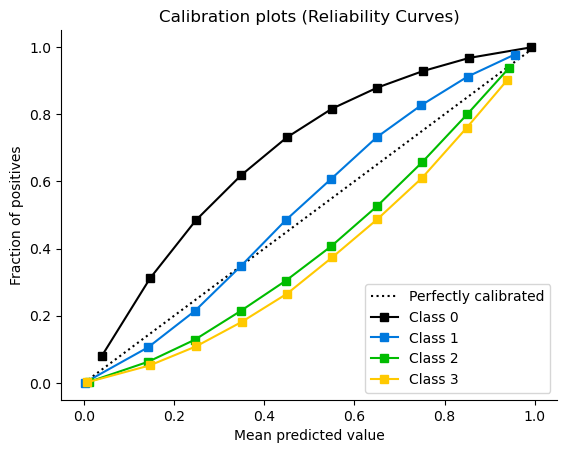

              precision    recall  f1-score   support

           0       0.98      0.93      0.96   1548525
           1       0.78      0.58      0.67     19369
           2       0.60      0.66      0.63     77414
           3       0.58      0.85      0.69    154829

    accuracy                           0.91   1800137
   macro avg       0.74      0.76      0.74   1800137
weighted avg       0.93      0.91      0.92   1800137

Calibrated catboost model


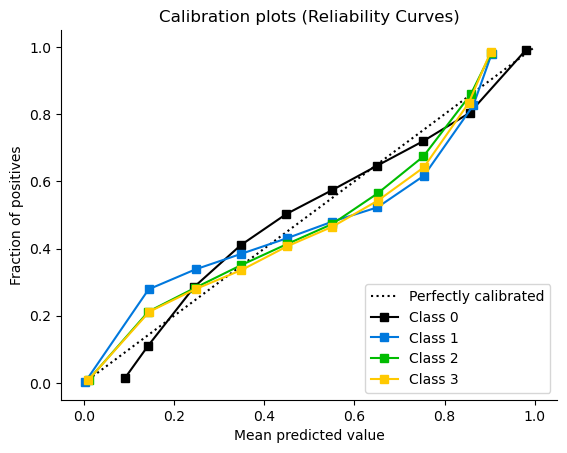

              precision    recall  f1-score   support

           0       0.96      0.97      0.97   1548525
           1       0.73      0.65      0.69     19369
           2       0.70      0.58      0.63     77414
           3       0.67      0.73      0.70    154829

    accuracy                           0.93   1800137
   macro avg       0.77      0.73      0.75   1800137
weighted avg       0.93      0.93      0.92   1800137



In [17]:
model = "catboost"
base = CatBoostClassifier()
base.load_model(clf_dict[model])
calib = CalibratedClassifierCV(base, cv="prefit")
calib.fit(X_val, y_val)
y_proba = calib.predict_proba(X_test)
y_proba_raw = base.predict_proba(X_test)
print(model)

# uncalibrated model
print("Uncalibrated " + model + " model")
plot.calibration_curve(
    [y_test == 0, y_test == 1, y_test == 2, y_test == 3],
    [y_proba_raw[:, 0], y_proba_raw[:, 1], y_proba_raw[:, 2], y_proba_raw[:, 3]],
    clf_names=["Class 0", "Class 1", "Class 2", "Class 3"],
)
plt.show()
print(classification_report(y_test, y_proba_raw.argmax(axis=1)))

# calibrated model
print("Calibrated " + model + " model")
plot.calibration_curve(
    [y_test == 0, y_test == 1, y_test == 2, y_test == 3],
    [y_proba[:, 0], y_proba[:, 1], y_proba[:, 2], y_proba[:, 3]],
    clf_names=["Class 0", "Class 1", "Class 2", "Class 3"],
)
plt.show()
print(classification_report(y_test, y_proba.argmax(axis=1)))

### MLP

In [18]:
model = "mlp"
loaded_model = torch.load(clf_nn_dict[model])
loaded_model.eval()

CropPL(
  (net): CropMLP(
    (net): Sequential(
      (0): Linear(in_features=164, out_features=1312, bias=True)
      (1): BatchNorm1d(1312, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=1312, out_features=656, bias=True)
      (5): BatchNorm1d(656, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.4, inplace=False)
      (8): Linear(in_features=656, out_features=328, bias=True)
      (9): BatchNorm1d(328, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.01)
      (11): Dropout(p=0.4, inplace=False)
      (12): Linear(in_features=328, out_features=164, bias=True)
      (13): BatchNorm1d(164, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): LeakyReLU(negative_slope=0.01)
      (15): Dropout(p=0.3, i

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

Uncalibrated mlp model
0.052423869692808066


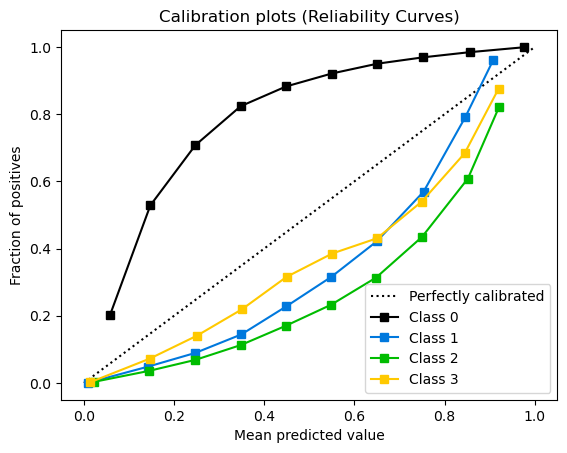

              precision    recall  f1-score   support

           0       0.99      0.87      0.92   1548525
           1       0.49      0.71      0.58     19369
           2       0.37      0.72      0.49     77414
           3       0.46      0.80      0.58    154829

    accuracy                           0.85   1800137
   macro avg       0.58      0.77      0.65   1800137
weighted avg       0.91      0.85      0.87   1800137



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

Calibrated mlp model
0.042424802533622574


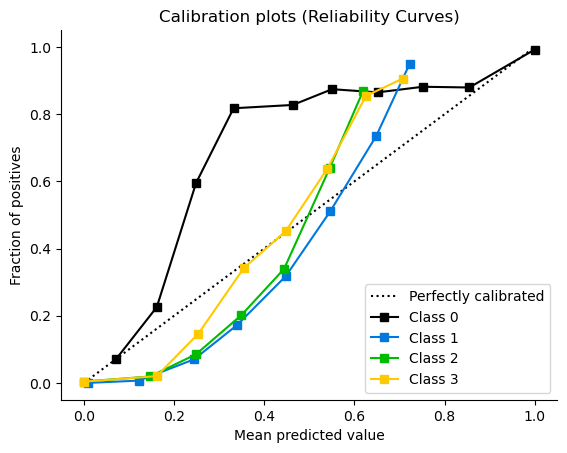

              precision    recall  f1-score   support

           0       0.99      0.87      0.92   1548525
           1       0.49      0.71      0.58     19369
           2       0.37      0.72      0.49     77414
           3       0.46      0.80      0.58    154829

    accuracy                           0.85   1800137
   macro avg       0.58      0.77      0.65   1800137
weighted avg       0.91      0.85      0.87   1800137



In [19]:
# check metrics
predictions = torch.cat(
    trainer.predict(loaded_model, DataLoader(X_test_nn, batch_size=2048)), dim=0
)
softmax = nn.Softmax(dim=1)
y_prob = softmax(predictions.float())

print("Uncalibrated " + model + " model")
print(calibration_multiclass(y_test, y_prob.numpy()))
plot.calibration_curve(
    [y_test == 0, y_test == 1, y_test == 2, y_test == 3],
    [y_prob[:, 0], y_prob[:, 1], y_prob[:, 2], y_prob[:, 3]],
    clf_names=["Class 0", "Class 1", "Class 2", "Class 3"],
)
plt.show()
print(classification_report(y_test, y_prob.numpy().argmax(axis=1)))

scaled_model = ModelWithTemperature(model=loaded_model.net, strategy="learn",
                                             per_class=True, device='cuda:1', verbose=True)
# Create a TensorDataset that combines X_val and y_val
dataset = TensorDataset(
    torch.tensor(X_val.values, dtype=torch.float),
    torch.tensor(y_val, dtype=torch.long).argmax(1),
)
# Pass the dataset to your DataLoader, along with any other relevant arguments
valid_loader = DataLoader(dataset, batch_size=2048)
temps = torch.linspace(0.25, 4.0, 100)
scaled_model.set_temperature(valid_loader, t_vals=list(temps))
scaled_model = CropPL(net=scaled_model)

# check metrics
predictions = torch.cat(
    trainer.predict(scaled_model, DataLoader(X_test_nn, batch_size=2048)), dim=0
)
y_prob = softmax(predictions.float())

print("Calibrated " + model + " model")
print(calibration_multiclass(y_test, y_prob.numpy()))
plot.calibration_curve(
    [y_test == 0, y_test == 1, y_test == 2, y_test == 3],
    [y_prob[:, 0], y_prob[:, 1], y_prob[:, 2], y_prob[:, 3]],
    clf_names=["Class 0", "Class 1", "Class 2", "Class 3"],
)
plt.show()
print(classification_report(y_test, y_prob.numpy().argmax(axis=1)))

### Transformer

In [21]:
model = "transformer"
loaded_model = torch.load(clf_nn_dict[model])
loaded_model.eval()

CropPL(
  (net): CropTransformer(
    (embedding): Linear(in_features=10, out_features=10, bias=True)
    (transformer_enc): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
          )
          (linear1): Linear(in_features=10, out_features=64, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=64, out_features=10, bias=True)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (classifier): Sequential(
      (0): Linear(in_features=54, out_features=54, bias=True)
      (1): LayerNorm((54,), eps=1e-05, elementwise_affine=True)
      (2): 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

Uncalibrated transformer model
0.07376276585475797


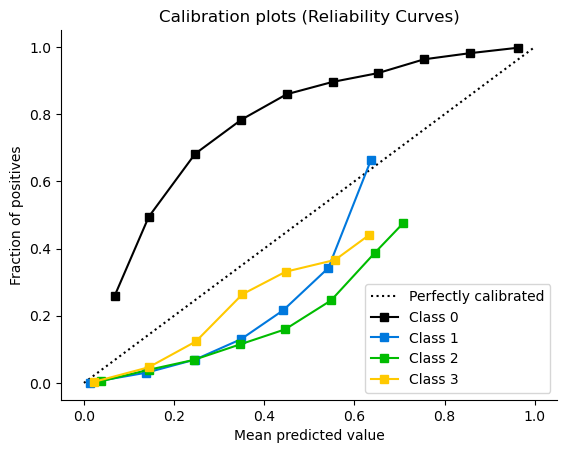

              precision    recall  f1-score   support

           0       0.97      0.84      0.90   1548525
           1       0.36      0.43      0.39     19369
           2       0.26      0.42      0.32     77414
           3       0.37      0.76      0.50    154829

    accuracy                           0.81   1800137
   macro avg       0.49      0.61      0.53   1800137
weighted avg       0.89      0.81      0.84   1800137



In [22]:
# check metrics
predictions = torch.cat(
    trainer.predict(
        loaded_model,
        DataLoader(
            CroplandDatasetTest((dm_lstm.X_monthly_test, dm_lstm.X_static_test)),
            batch_size=2048,
        ),
    ),
    dim=0,
)
softmax = nn.Softmax(dim=1)
y_prob = softmax(predictions.float())

print("Uncalibrated " + model + " model")
print(calibration_multiclass(y_test, np.array(y_prob)))
plot.calibration_curve(
    [y_test == 0, y_test == 1, y_test == 2, y_test == 3],
    [y_prob[:, 0], y_prob[:, 1], y_prob[:, 2], y_prob[:, 3]],
    clf_names=["Class 0", "Class 1", "Class 2", "Class 3"],
)
plt.show()
print(classification_report(y_test, y_prob.numpy().argmax(axis=1)))

### LSTM

In [24]:
model = "lstm"
loaded_model = torch.load(clf_nn_dict[model])
loaded_model.eval()

CropPL(
  (net): CropLSTM(
    (lstm): LSTM(10, 128, batch_first=True, dropout=0.2, bidirectional=True)
    (classifier): Sequential(
      (0): Linear(in_features=300, out_features=300, bias=True)
      (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_features=300, out_features=4, bias=True)
    )
  )
  (criterion): CrossEntropyLoss()
  (softmax): Softmax(dim=None)
  (train_loss): MeanMetric()
  (val_loss): MeanMetric()
  (test_loss): MeanMetric()
  (val_F1Score_best): MaxMetric()
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (train_avg_precision): MulticlassAveragePrecision()
  (val_avg_precision): MulticlassAveragePrecision()
  (test_avg_precision): MulticlassAveragePrecision()
  (train_precision): MulticlassPrecision()
  (val_precision): MulticlassPrecision()
  (test_precision): MulticlassPre

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

Uncalibrated lstm model
0.0834451954833064


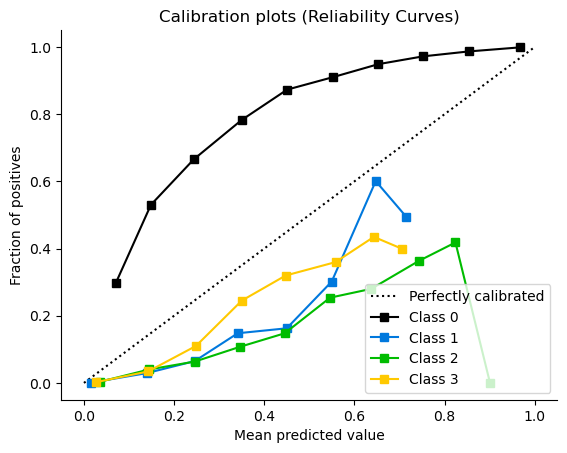

              precision    recall  f1-score   support

           0       0.97      0.83      0.89   1548525
           1       0.31      0.39      0.34     19369
           2       0.23      0.39      0.29     77414
           3       0.36      0.76      0.49    154829

    accuracy                           0.80   1800137
   macro avg       0.47      0.59      0.51   1800137
weighted avg       0.88      0.80      0.83   1800137



In [25]:
# check metrics
predictions = torch.cat(
    trainer.predict(
        loaded_model,
        DataLoader(
            CroplandDatasetTest((dm_lstm.X_monthly_test, dm_lstm.X_static_test)),
            batch_size=2048,
        ),
    ),
    dim=0,
)
softmax = nn.Softmax(dim=1)
y_prob = softmax(predictions.float())

print("Uncalibrated " + model + " model")
print(calibration_multiclass(y_test, y_prob.numpy()))
plot.calibration_curve(
    [y_test == 0, y_test == 1, y_test == 2, y_test == 3],
    [y_prob[:, 0], y_prob[:, 1], y_prob[:, 2], y_prob[:, 3]],
    clf_names=["Class 0", "Class 1", "Class 2", "Class 3"],
)
plt.show()
print(classification_report(y_test, y_prob.numpy().argmax(axis=1)))

In [39]:
model = "conv_lstm"
loaded_model = torch.load(clf_nn_dict[model])
loaded_model.eval()

CropPL(
  (net): CropConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv1d(17, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      )
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (net): Sequential(
      (0): Linear(in_features=1964, out_features=192, bias=True)
      (1): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=192, out_features=12, bias=True)
      (5): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.4, inplace=False)
      (8): Linear(in_features=12, out_features=4, bias=True)
    )
  )
  (criterion): CrossEntropyLoss()
  (softmax): Softmax(dim=None)
  (train_loss): MeanMetric()
  (val_loss): MeanMetric()
  (test_loss): MeanMetric()
  (val_F1Score_best): MaxMetric()
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

Uncalibrated conv_lstm model
0.05517551468029118


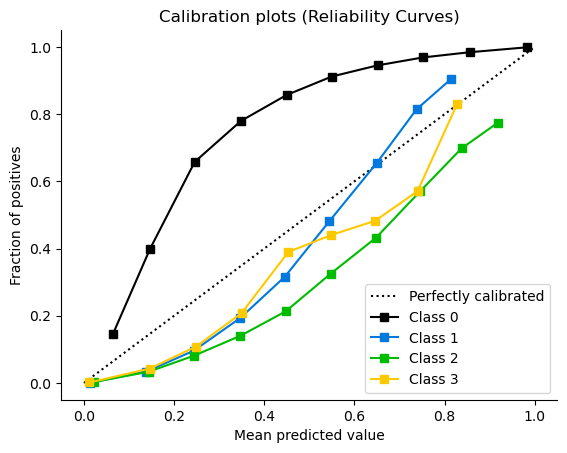

              precision    recall  f1-score   support

           0       0.98      0.87      0.92   1548525
           1       0.52      0.46      0.49     19369
           2       0.37      0.61      0.46     77414
           3       0.44      0.81      0.57    154829

    accuracy                           0.85   1800137
   macro avg       0.58      0.69      0.61   1800137
weighted avg       0.91      0.85      0.87   1800137



In [40]:

# check metrics
predictions = torch.cat(
    trainer.predict(
        loaded_model,
        DataLoader(
            CroplandDatasetTest((dm_lstm.X_monthly_test, dm_lstm.X_static_test)),
            batch_size=2048,
        ),
    ),
    dim=0,
)
softmax = nn.Softmax(dim=1)
y_prob = softmax(predictions.float())

print("Uncalibrated " + model + " model")
print(calibration_multiclass(y_test, np.array(y_prob)))
plot.calibration_curve(
    [y_test == 0, y_test == 1, y_test == 2, y_test == 3],
    [y_prob[:, 0], y_prob[:, 1], y_prob[:, 2], y_prob[:, 3]],
    clf_names=["Class 0", "Class 1", "Class 2", "Class 3"],
)
plt.show()
print(classification_report(y_test, y_prob.numpy().argmax(axis=1)))

## Calculate metrics for all models in a sequence

In [41]:
### Calculate metrics for all models in a sequence
y_probs = f1_scores = dict()

for model in tqdm(clf_dict):
    if model == "catboost":
        loaded_model = CatBoostClassifier()
        loaded_model.load_model(clf_dict[model])
        path_to_save = os.path.join("..", "results", "ensemble", "catboost")
    else:
        loaded_model = pickle.load(open(clf_dict[model], "rb"))
        path_to_save = None
    y_pred = loaded_model.predict(X_test)
    y_prob = loaded_model.predict_proba(X_test)
    y_probs[model] = y_prob

    print(model + " results:")
    rep = classification_report(y_test, y_pred, output_dict=True)
    df = pd.DataFrame(rep).transpose()
    print(df)
    f1_scores[model] = df.iloc[5, 2]

    if path_to_save is not None:
        df.to_csv(os.path.join(path_to_save, "metrics.csv"), index=True)

    # To see confusion matrices and class distributions run
    # custom_multiclass_report(y_test, y_pred, y_probs[model])

  0%|          | 0/2 [00:00<?, ?it/s]

lr results:


 50%|█████     | 1/2 [00:06<00:06,  6.59s/it]

              precision    recall  f1-score       support
0              0.953062  0.885305  0.917935  1.548525e+06
1              0.612950  0.239971  0.344909  1.936900e+04
2              0.296084  0.193957  0.234379  7.741400e+04
3              0.384515  0.753509  0.509191  1.548290e+05
accuracy       0.837295  0.837295  0.837295  8.372946e-01
macro avg      0.561653  0.518186  0.501603  1.800137e+06
weighted avg   0.872249  0.837295  0.847217  1.800137e+06
catboost results:


100%|██████████| 2/2 [03:10<00:00, 95.11s/it] 

              precision    recall  f1-score       support
0              0.982932  0.933748  0.957709  1.548525e+06
1              0.778569  0.581083  0.665484  1.936900e+04
2              0.604821  0.664738  0.633366  7.741400e+04
3              0.575107  0.852689  0.686915  1.548290e+05
accuracy       0.911413  0.911413  0.911413  9.114129e-01
macro avg      0.735358  0.758064  0.735869  1.800137e+06
weighted avg   0.929396  0.911413  0.917326  1.800137e+06


In [20]:
### Calculate metrics for all NN models in a sequence
softmax = nn.Softmax(dim=1)

for model in tqdm(clf_nn_dict):
    if "mlp" in model:
        network = CropMLP()
        loaded_model = CropPL(net=network)
        loaded_model = torch.load(clf_nn_dict[model])
        loaded_model.eval()

        # check metrics
        predictions = torch.cat(
            trainer.predict(loaded_model, DataLoader(X_test_nn, batch_size=2048)), dim=0
        )
        # softmax = nn.Softmax(dim=1)
        y_prob = softmax(predictions.float()).numpy()
        y_pred = np.argmax(y_prob, 1)
        y_probs[model] = y_prob

    elif "transformer" in model:
        network = CropTransformer()
        loaded_model = CropPL(net=network)
        loaded_model = torch.load(clf_nn_dict[model])
        loaded_model.eval()

        # check metrics
        predictions = torch.cat(
            trainer.predict(
                loaded_model,
                DataLoader(
                    CroplandDatasetTest(
                        (dm_lstm.X_monthly_test, dm_lstm.X_static_test)
                    ),
                    batch_size=2048,
                ),
            ),
            dim=0,
        )
        # softmax = nn.Softmax(dim=1)
        y_prob = softmax(predictions.float()).numpy()
        y_pred = np.argmax(y_prob, 1)
        y_probs[model] = y_prob

    elif "conv_lstm" in model:
        network = CropConvLSTM()
        loaded_model = CropPL(net=network)
        try:
            loaded_model = torch.load(clf_nn_dict[model])
        except AttributeError:
            try:
                checkpoint = torch.load(clf_dict[model][:-4] + ".ckpt")
                loaded_model.load_state_dict(checkpoint["state_dict"])
            except:
                pass
        loaded_model.eval()

        # check metrics
        predictions = torch.cat(
            trainer.predict(
                loaded_model,
                DataLoader(
                    CroplandDatasetTest(
                        (dm_lstm.X_monthly_test, dm_lstm.X_static_test)
                    ),
                    batch_size=2048,
                ),
            ),
            dim=0,
        )
        # softmax = nn.Softmax(dim=1)
        y_prob = softmax(predictions.float()).numpy()
        y_pred = np.argmax(y_prob, 1)
        y_probs[model] = y_prob

    elif "lstm" in model:
        network = CropLSTM()
        loaded_model = CropPL(net=network)
        loaded_model = torch.load(clf_nn_dict[model])
        loaded_model.eval()

        # check metrics
        predictions = torch.cat(
            trainer.predict(
                loaded_model,
                DataLoader(
                    CroplandDatasetTest(
                        (dm_lstm.X_monthly_test, dm_lstm.X_static_test)
                    ),
                    batch_size=2048,
                ),
            ),
            dim=0,
        )
        # softmax = nn.Softmax(dim=1)
        y_prob = softmax(predictions.float()).numpy()
        y_pred = np.argmax(y_prob, 1)
        y_probs[model] = y_prob

    print(model + " results:")
    rep = classification_report(y_test, y_pred, output_dict=True)
    df = pd.DataFrame(rep).transpose()
    print(df)
    f1_scores[model] = df.iloc[5, 2]
    # custom_multiclass_report(y_test, y_pred, y_probs[model])

  0%|          | 0/4 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

mlp results:


 25%|██▌       | 1/4 [00:12<00:38, 12.78s/it]

              precision    recall  f1-score       support
0              0.989390  0.865182  0.923127  1.548525e+06
1              0.462372  0.705147  0.558518  1.936900e+04
2              0.375876  0.680290  0.484213  7.741400e+04
3              0.440468  0.786222  0.564618  1.548290e+05
accuracy       0.848718  0.848718  0.848718  8.487176e-01
macro avg      0.567027  0.759211  0.632619  1.800137e+06
weighted avg   0.910123  0.848718  0.869493  1.800137e+06


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

lstm results:


 50%|█████     | 2/4 [00:46<00:49, 24.96s/it]

              precision    recall  f1-score       support
0              0.971935  0.841587  0.902077  1.548525e+06
1              0.353001  0.392896  0.371882  1.936900e+04
2              0.235576  0.408505  0.298826  7.741400e+04
3              0.381639  0.748070  0.505427  1.548290e+05
accuracy       0.810092  0.810092  0.810092  8.100917e-01
macro avg      0.485538  0.597765  0.519553  1.800137e+06
weighted avg   0.882838  0.810092  0.836314  1.800137e+06


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

conv_lstm results:


 75%|███████▌  | 3/4 [01:29<00:33, 33.29s/it]

              precision    recall  f1-score       support
0              0.984734  0.865599  0.921331  1.548525e+06
1              0.527639  0.443028  0.481646  1.936900e+04
2              0.355998  0.608159  0.449104  7.741400e+04
3              0.435000  0.816016  0.567486  1.548290e+05
accuracy       0.845717  0.845717  0.845717  8.457167e-01
macro avg      0.575843  0.683200  0.604892  1.800137e+06
weighted avg   0.905495  0.845717  0.865858  1.800137e+06


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

trans results:


100%|██████████| 4/4 [01:52<00:00, 28.10s/it]

              precision    recall  f1-score       support
0              0.974723  0.838617  0.901562  1.548525e+06
1              0.353238  0.426042  0.386239  1.936900e+04
2              0.258123  0.441186  0.325693  7.741400e+04
3              0.373774  0.753593  0.499701  1.548290e+05
accuracy       0.809774  0.809774  0.809774  8.097739e-01
macro avg      0.489964  0.614860  0.528299  1.800137e+06
weighted avg   0.885531  0.809774  0.836689  1.800137e+06


In [21]:
# F1 scores macro average
for k, v in f1_scores.items():
    print(k, v)

lr 0.5015691035662954
catboost 0.734890737357009
mlp 0.6326190652844944
lstm 0.5195529438269466
conv_lstm 0.6048915816758633
trans 0.5282989917620081


## Save predictions

In [8]:
import glob
import joblib

In [5]:
def make_predictions(X, clf_dict):
    """Generates predictions using different models based on provided dataset

    Args:
        X (Array or DataFrame): features

    Returns:
        y_probs: dict
        keys - model name
        values - array of probabilities
    """
    y_probs = dict()

    for model in tqdm(clf_dict):
        if model == "mlp":
            network = CropMLP()
            # checkpoint = torch.load(clf_dict[model])
            loaded_model = CropPL(net=network)
            loaded_model = torch.load(clf_dict[model])
            loaded_model.eval()

            # create an instance of pl.Trainer
            trainer = pl.Trainer(gpus=1)

            # check metrics
            predictions = torch.cat(
                trainer.predict(
                    loaded_model,
                    DataLoader(
                        torch.tensor(X.values, dtype=torch.float), batch_size=2048
                    ),
                ),
                dim=0,
            )
            softmax = nn.Softmax(dim=1)
            y_prob = softmax(predictions.float()).numpy()
            y_probs[model] = y_prob

        elif model == "lstm":
            network = CropLSTM()
            # checkpoint = torch.load(clf_dict[model])
            loaded_model = CropPL(net=network)
            loaded_model = torch.load(clf_dict[model])
            # loaded_model.load_state_dict(checkpoint["state_dict"])
            loaded_model.eval()

            # create an instance of pl.Trainer
            trainer = pl.Trainer(gpus=1)

            # check metrics
            predictions = torch.cat(
                trainer.predict(
                    loaded_model,
                    DataLoader(
                        torch.tensor(reshape_data(X), dtype=torch.float),
                        batch_size=2048,
                    ),
                ),
                dim=0,
            )
            softmax = nn.Softmax(dim=1)
            y_prob = softmax(predictions.float()).numpy()
            y_probs[model] = y_prob

        elif model == "transformer":
            network = CropConvLSTM()
            # checkpoint = torch.load(clf_dict[model])
            loaded_model = CropPL(net=network)
            loaded_model = torch.load(clf_dict[model])
            # loaded_model.load_state_dict(checkpoint["state_dict"])
            loaded_model.eval()

            # create an instance of pl.Trainer
            trainer = pl.Trainer(gpus=1)

            # check metrics
            predictions = torch.cat(
                trainer.predict(
                    loaded_model,
                    DataLoader(
                        torch.tensor(reshape_data(X), dtype=torch.float),
                        batch_size=2048,
                    ),
                ),
                dim=0,
            )
            softmax = nn.Softmax(dim=1)
            y_prob = softmax(predictions.float()).numpy()
            y_probs[model] = y_prob

        elif model == "conv_lstm":
            network = CropConvLSTM()
            # checkpoint = torch.load(clf_dict[model])
            loaded_model = CropPL(net=network)
            loaded_model = torch.load(clf_dict[model])
            # loaded_model.load_state_dict(checkpoint["state_dict"])
            loaded_model.eval()

            # create an instance of pl.Trainer
            trainer = pl.Trainer(gpus=1)

            # check metrics
            predictions = torch.cat(
                trainer.predict(
                    loaded_model,
                    DataLoader(
                        torch.tensor(reshape_data(X), dtype=torch.float),
                        batch_size=2048,
                    ),
                ),
                dim=0,
            )
            softmax = nn.Softmax(dim=1)
            y_prob = softmax(predictions.float()).numpy()
            y_probs[model] = y_prob

        else:
            # loading the models:
            loaded_model = pickle.load(open(clf_dict[model], "rb"))
            y_prob = loaded_model.predict_proba(X)
            y_probs[model] = y_prob

    return y_probs

In [4]:
# defining paths
path_to_npys_data = os.path.join("..", "data", "npys_data")

pathFeatures = os.path.join(path_to_npys_data, "2040_2050")
pathResults = os.path.join("..", "results", "2040_2050")
pathMorf = os.path.join(path_to_npys_data, "features_morf_data.npy")

# softmax = nn.Softmax()

In [6]:
clf_nn_dict = {
    "mlp": os.path.join(path_to_pickled_models, "mlp.pkl"),
    # "lstm": os.path.join(path_to_pickled_models, "lstm.pkl"),
    # "conv_lstm": os.path.join(path_to_pickled_models, "conv_lstm.pkl"),
    # "transformer": os.path.join(path_to_pickled_models, "transformer.pkl"),
}

In [10]:
# load morf features separately
morf = pd.DataFrame.from_dict(np.load(pathMorf, allow_pickle=True), orient="columns")
morf.drop(columns=["latitude", "longitude"], inplace=True)

# Load features keys
with open(os.path.join(path_to_npys_data, "X_keys.pkl"), "rb") as fp:
    keys = pickle.load(fp)

softmax = nn.Softmax(dim=1)

# Iterate through climate scenarios and models
for path in tqdm(glob.glob(os.path.join(pathFeatures, "*.npy"))):
    file_name = path.split("/")[-1]  # get the file name from the path
    ssp = file_name.split("_")[1]  # get sspXXX from the file name
    geo_model = file_name.split("_")[2].split(".")[
        0
    ]  # get MRI/CNRM/CMCC from the file name

    if ssp == "ssp245":
        # Loading Features
        X = pd.DataFrame.from_dict(np.load(path, allow_pickle=True), orient="columns")
        # Concat climate and morf features
        # X = X.merge(morf, on = ["latitude", "longitude"])
        X = pd.concat([X, morf], axis=1)
        # make specific order of features
        X = X[keys]
        X = X.replace(-np.inf, 0)
        X = X.replace(np.inf, 0)

        # Define scaler based on whole dataset
        scaler = joblib.load(os.path.join(path_to_npys_data, "scaler_FR.save"))
        # Normalization using minmax scaler
        X = pd.DataFrame(scaler.transform(X), columns=keys)

        # Making predictions
        probabilities = make_predictions(X, clf_nn_dict)

        # Saving results:
        for model in probabilities:
            with open(
                os.path.join(
                    pathResults, "_".join([model, ssp, geo_model, "prob.npy"])
                ),
                "wb",
            ) as f:
                pickle.dump(probabilities[model], f, protocol=4)

  0%|          | 0/9 [00:00<?, ?it/s]

/home/crop_dev/miniconda/envs/crop_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

 11%|█         | 1/9 [07:24<59:17, 444.71s/it]/home/crop_dev/miniconda/envs/crop_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

 89%|████████▉ | 8/9 [18:41<02:08, 128.28s/it]/home/crop_dev/miniconda/envs/crop_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

100%|██████████| 9/9 [27:56<00:00, 186.32s/it]


In [11]:
cmcc = np.load(
    os.path.join("..", "results", "2040_2050", "mlp_ssp245" + "_CMCC_prob.npy"),
    allow_pickle=True,
)
cnrm = np.load(
    os.path.join("..", "results", "2040_2050", "mlp_ssp245" + "_CNRM_prob.npy"),
    allow_pickle=True,
)
mri = np.load(
    os.path.join("..", "results", "2040_2050", "mlp_ssp245" + "_MRI_prob.npy"),
    allow_pickle=True,
)

average = np.mean([cmcc, cnrm, mri], axis=0)
with open(
    os.path.join("..", "results", "2040_2050", "mlp_ssp245" + "_average_prob.npy"),
    "wb",
) as f:
    pickle.dump(average, f, protocol=4)

## Plot heatmaps

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr
import xarray as xr
import seaborn as sns
from matplotlib.patches import Rectangle

In [13]:
# defining paths
model = "mlp"
path_to_npys_data = os.path.join("..", "data", "npys_data")

path_to_geo_data = os.path.join("..", "data", "geo_data")

pathTarget = os.path.join(path_to_npys_data, "target_croplands.npy")

pathPrediction = os.path.join(
    "..", "results", "2040_2050", "{}_ssp245_average_prob.npy".format(model)
)

path_to_figs = os.path.join("..", "results", "prob_subs")

In [14]:
# Loading GFSAD cropmask and use it as initial probability distribution. Class 4 denotes Nans in the dataset.

with open(pathTarget, "rb") as f:
    init_data = pickle.load(f)
    tgt = init_data["Target"]
    # Set classes 4,5 to 0
    tgt[np.isnan(tgt)] = 6
    tgt = tgt.astype(np.int16)
    tgt = np.where(tgt == 5, 0, tgt)
    tgt = np.where(tgt == 4, 0, tgt)
    tgt = np.where(tgt == 6, 4, tgt)
    uniques = np.unique(tgt)
    n_values = len(uniques)
    tgt_ohe = np.eye(n_values)[tgt]
    init_data = tgt_ohe

In [15]:
# Load prediction and filters

# Predicted probabilites by LSTM model for 2050 year
with open(pathPrediction, "rb") as f:
    predicted_prob = pickle.load(f)

# Tif file where 0s represent water area (no cropland is possible)
filter_water = rxr.open_rasterio(
    os.path.join(path_to_geo_data, "filter_water_new.tif")
).squeeze()

# Tif file where 0s represent area with slope > 5 degrees (no cropland is possible)
filter_slope = rxr.open_rasterio(
    os.path.join(path_to_geo_data, "filter_slope_new.tif")
).squeeze()

class diff 0


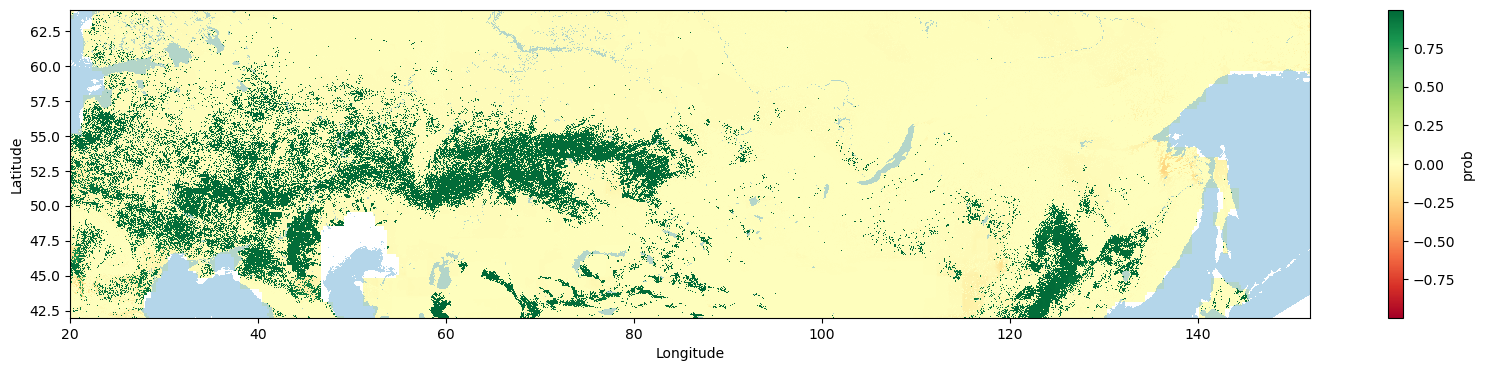

class diff 1


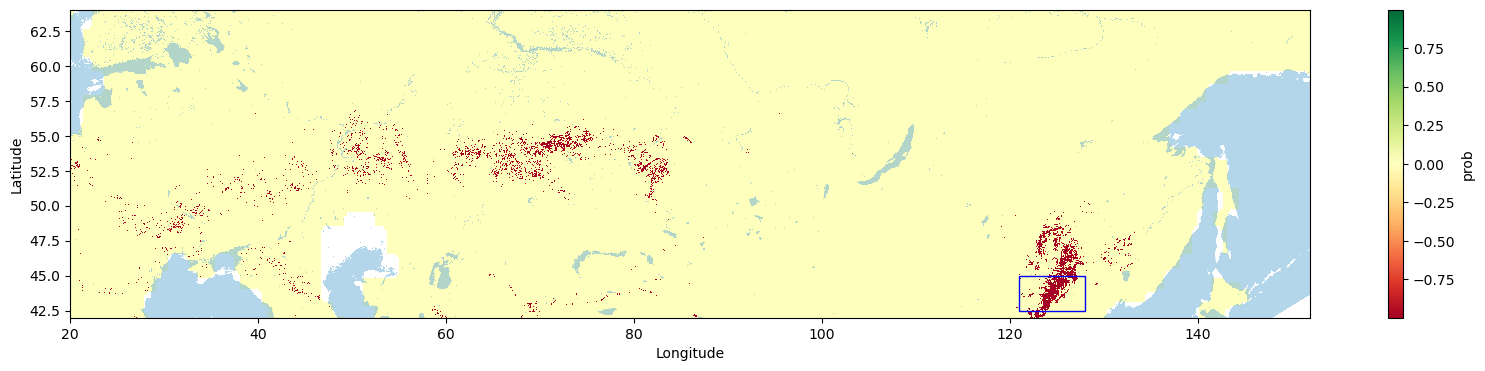

class diff 2


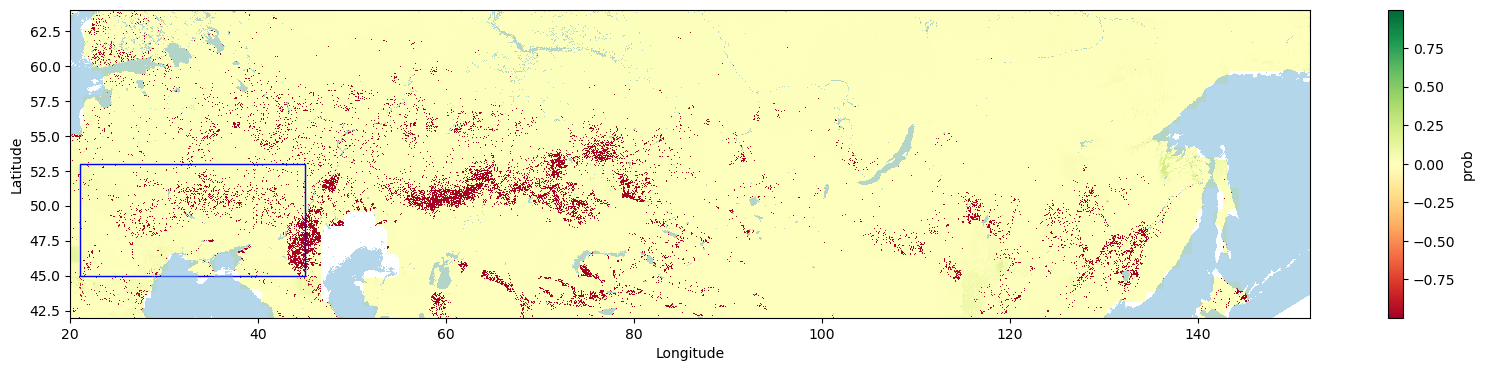

class diff 3


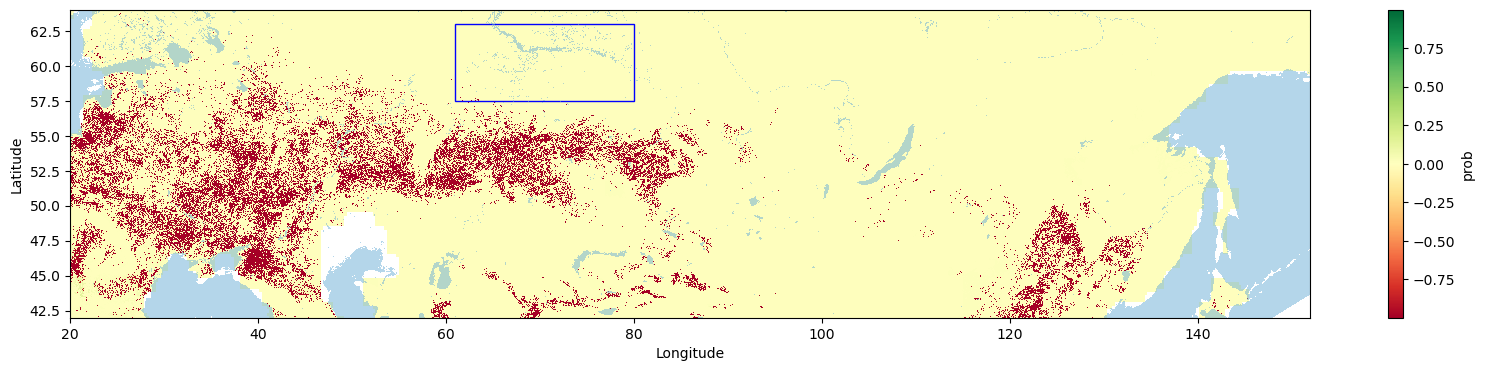

In [16]:
# Plot differences
# Define dimensions for xr.DataArray based on Filter file:
x, y = filter_slope.indexes.values()
lot = y.shape[0]

# Plot heatmap for each class:
for j in range(4):
    predicted_prob_filtered = [
        z * h
        for z, h in zip(predicted_prob[:, j].reshape(lot, -1), filter_water.values)
    ]
    init_data_filtered = [
        z * h for z, h in zip(init_data[:, j].reshape(lot, -1), filter_water.values)
    ]
    predicted_prob_filtered = [
        z * h for z, h in zip(predicted_prob_filtered, filter_slope.values)
    ]
    init_data_filtered = [
        z * h for z, h in zip(init_data_filtered, filter_slope.values)
    ]

    diff_probability = np.subtract(predicted_prob_filtered, init_data_filtered)
    diff_probability = diff_probability.reshape(-1)

    # Add rectangles
    rectangles = [
        (45, 121, 42.5, 128),  # [ul_corner_y, ul_corner_x, lr_corner_y, lr_corner_x]
        (53, 21, 45, 45),
        (63, 61, 57.5, 80),
    ]

    filter_water_ = filter_water.where(filter_water == 0)
    diff_probability = xr.DataArray(
        diff_probability.reshape(lot, -1), dims=["y", "x"], coords=dict(y=y, x=x)
    )
    diff_probability.name = "prob"

    # Plotting
    fig, gax = plt.subplots(figsize=(20, 4))

    # Plot rectangle
    if j != 0:
        ul_corner_y, ul_corner_x, lr_corner_y, lr_corner_x = rectangles[j - 1]
        width = lr_corner_x - ul_corner_x
        height = lr_corner_y - ul_corner_y
        rect = Rectangle(
            (ul_corner_x, ul_corner_y),
            width,
            height,
            linewidth=1,
            edgecolor="b",
            facecolor="none",
        )
        gax.add_patch(rect)

    # Plot heatmap
    filter_water_.plot(ax=gax, cmap="Blues", add_colorbar=False, alpha=0.5)
    diff_probability.plot.imshow(ax=gax, cmap="RdYlGn")
    # plt.savefig(os.path.join(path_to_figs, 'catboost_ssp245_average_class_diff_' + str(j) + '.png'))
    print("class diff " + str(j))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
    plt.close(fig)